In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import matplotlib.pyplot as plt
import random

import wandb
import os

In [2]:
spectra = pd.read_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/scaled_spectra_with_instrument_type.csv')

# Plotting Function Definitions:
---

In [3]:
def get_weighted_cosine_similarity(output, target):
  # it is common to use m/z ratio as weights since fragments with higher m/z ratios are more important.
  mz = torch.arange(1, len(target)+1)

  numerator = torch.sum(mz*output*target)
  output_denom = torch.sqrt(torch.sum(mz*output**2))
  target_denom = torch.sqrt(torch.sum(mz*target**2))

  weighted_cosine_similarity = numerator/(output_denom*target_denom)
  return(weighted_cosine_similarity)

In [4]:
# def plot_results(real_spectra, fake_spectra, labels, idx=[0,5], window=300, cutoff = 0.5):
#   """
#   Plot and compare real and synthetic spectra within a specified index range.

#   Takes in real, noisy, and synthetic spectra and plots them for comparison.
#   Computes and prints the weighted cosine similarity between the real spectrum and 
#   both the noisy and synthetic spectra.

#   Args:
#       real_spectra (list of list of float): List of real spectra, where each spectrum is a list of intensity values.
#       fake_spectra (list of list of float): List of synthetic spectra generated by decoder.
#       labels (list of str): List of chemical name labels corresponding to each spectrum.
#       idx (list of int, optional): Range of indices to plot. Default is [0, 10].
#       window (int, optional): Highest m/z to plot for each spectrum. Default is 300.
#       cutoff (float, optional): Intensity cutoff threshold to filter out low-intensity noise. Default is 0.5.
#   """
#   for i, (real_spec, fake_spec) in enumerate(zip(real_spectra, fake_spectra)):
#     # only plot spectra within the specified index range
#     if i > idx[1]:
#       break
#     if idx[0] <= i < idx[1]:
#       # Define the x-axis range
#       numbers = range(0, window)
      
#       # Scale the real spectrum so highest peak is 100
#       input_frequencies = real_spec.copy()
#       input_max = max(input_frequencies)
#       scaled_input = [num/input_max * 100 for num in input_frequencies]

#       # No need to scale noisy spectrum, plot should display what the input to the model looked like

#       # Scale the synthetic spectrum so highest peak is 100
#       out_clone = fake_spec.copy()
#       output_max = max(out_clone)
#       scaled_out = [num/output_max * 100 for num in out_clone]
#       out_frequencies = [0 if num < cutoff else num for num in scaled_out]

#       weighted_cosine_similarity = get_weighted_cosine_similarity(out_clone, input_frequencies)

#       # Create a plot with 2 subplots for real and synthetic spectra
#       _, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 10))

#       ax[0].bar(numbers, scaled_input[:window])
#       ax[0].set_title(f'True {labels[i]} Spectrum.', fontsize=18)
#       ax[0].set_xlabel('Mass to Charge Ratio', fontsize=16)
#       ax[0].set_ylabel('Intensity', fontsize=16)

#       ax[1].bar(numbers, out_frequencies[:window])
#       ax[1].set_title(f'Synthetic {labels[i]} Spectrum.', fontsize=18)
#       print('Weighted cosine similarity between true spectrum and output spectrum is: ', round(float(weighted_cosine_similarity), 2))
#       ax[1].set_xlabel('Mass to Charge Ratio', fontsize=16)
#       ax[1].set_ylabel('Intensity', fontsize=16)

#       plt.tight_layout()
#       plt.show()

In [5]:
def plot_results_with_input(real_spectra, noisy_spectra, fake_spectra, labels, idx=[0,5], window=300, cutoff = 0.5):
  """
  Plot and compare real, noisy, and synthetic spectra within a specified index range.

  Takes in real, noisy, and synthetic spectra and plots them for comparison.
  Computes and prints the weighted cosine similarity between the real spectrum and 
  both the noisy and synthetic spectra.

  Args:
      real_spectra (list of list of float): List of real spectra, where each spectrum is a list of intensity values.
      noisy_spectra (list of list of float): List of noisy spectra.
      fake_spectra (list of list of float): List of synthetic spectra generated by decoder.
      labels (list of str): List of chemical name labels corresponding to each spectrum.
      idx (list of int, optional): Range of indices to plot. Default is [0, 10].
      window (int, optional): Highest m/z to plot for each spectrum. Default is 300.
      cutoff (float, optional): Intensity cutoff threshold to filter out low-intensity noise. Default is 0.5.
  """
  for i, (real_spec, noisy_spec, fake_spec) in enumerate(zip(real_spectra, noisy_spectra, fake_spectra)):
    # only plot spectra within the specified index range
    if i > idx[1]:
      break
    if idx[0] <= i < idx[1]:
      # Define the x-axis range
      numbers = range(0, window)
      
      # Scale the real spectrum so highest peak is 100
      real_frequencies = real_spec.copy()
      real_max = max(real_frequencies)
      scaled_real = [num/real_max * 100 for num in real_frequencies]

      # Scaling noisy spectra by same factor as real spectra
      noisy_frequencies = noisy_spec.copy()
      noisy_scaled = [num/real_max * 100 for num in noisy_frequencies]

      # Scale the synthetic spectrum so highest peak is 100
      out_clone = fake_spec.copy()
      output_max = max(out_clone)
      scaled_out = [num/output_max * 100 for num in out_clone]
      out_frequencies = [0 if num < cutoff else num for num in scaled_out]

      # noisy_weighted_cosine_similarity = get_weighted_cosine_similarity(noisy_spec, input_frequencies)
      noisy_weighted_cosine_similarity = get_weighted_cosine_similarity(noisy_frequencies, real_frequencies)
      weighted_cosine_similarity = get_weighted_cosine_similarity(out_clone, real_frequencies)

      # Create a plot with 3 subplots for real, noisy, and synthetic spectra
      _, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(20, 10))

      ax[0].bar(numbers, scaled_real[:window])
      ax[0].set_title(f'True {labels[i]} Spectrum.', fontsize=18)
      ax[0].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[0].set_ylabel('Intensity', fontsize=16)

      ax[1].bar(numbers, noisy_scaled[:window])
      ax[1].set_title(f'Noisy {labels[i]} Spectrum.', fontsize=18)
      print('Weighted cosine similarity between true spectrum and noisy spectrum is: ', round(float(noisy_weighted_cosine_similarity), 4))
      ax[1].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[1].set_ylabel('Intensity', fontsize=16)

      ax[2].bar(numbers, out_frequencies[:window])
      ax[2].set_title(f'Synthetic {labels[i]} Spectrum.', fontsize=18)
      print('Weighted cosine similarity between true spectrum and output spectrum is: ', round(float(weighted_cosine_similarity), 4))
      ax[2].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[2].set_ylabel('Intensity', fontsize=16)

      plt.tight_layout()
      plt.show()

# Model Definition:
---

In [6]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.model = nn.Sequential(
      nn.Linear(915,851),
      nn.LeakyReLU(inplace=True),
      nn.Linear(851,787),
      nn.LeakyReLU(inplace=True),
      nn.Linear(787, 723),
      nn.LeakyReLU(inplace=True),
      nn.Linear(723,659),
      nn.LeakyReLU(inplace=True),
      nn.Linear(659, 723),
      nn.LeakyReLU(inplace=True),
      nn.Linear(723,787),
      nn.LeakyReLU(inplace=True),
      nn.Linear(787,851),
      nn.LeakyReLU(inplace=True),
      nn.Linear(851, 915),
    )

  def forward(self, x):
    x = self.model(x)
    return x

# Generate Dataset:
---

In [7]:
# create list of chemical names
spectra_names = [chem.split('.')[0] for chem in spectra.columns]

# separate spectrum data from chemical name encodings
# true_spec_data = spectra[:][:915].values.T 
true_spec_data = spectra.values.T 
encoded_names = torch.tensor(spectra[:][915:965].values, dtype=torch.float32).T

In [21]:
def generate_dataset(noise_pct):
    noisy_spectra_train = []
    true_spectra_train = []
    train_name_encodings = []

    noisy_spectra_test = []
    true_spectra_test = []
    test_name_encodings = []

    spectra_copy = true_spec_data.copy()

    # Add noise to the spectra
    for i, spec in enumerate(spectra_copy):
        true_spec = spec.copy()

        noise = noise_pct * 915
        random_numbers = random.sample(range(915), int(round(noise)))
        for i in random_numbers:
            spec[i] = 0

        # using same chemical used in dynamical systems model, Benzyl Benzoate
        if sorted(list(set(spectra_names)))[list(spec[915:965]).index(1)] == 'Benzyl Benzoate':
            # if list(spec[-12:]).index(1) == 8:
            noisy_spectra_test.append(spec[:915])
            true_spectra_test.append(true_spec[:915])
            test_name_encodings.append(true_spec[915:965])
            # else:
            #     noisy_spectra_train.append(spec[:915])
            #     true_spectra_train.append(true_spec[:915])
            #     train_name_encodings.append(true_spec[915:965])
        else:
            noisy_spectra_train.append(spec[:915])
            true_spectra_train.append(true_spec[:915])
            train_name_encodings.append(true_spec[915:965])

    noisy_spectra_train_tensor = torch.tensor(noisy_spectra_train, dtype=torch.float32)
    true_spectra_train_tensor = torch.tensor(true_spectra_train, dtype=torch.float32)
    train_dataset = TensorDataset(noisy_spectra_train_tensor, true_spectra_train_tensor, torch.tensor(train_name_encodings))
    train_dataset = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

    noisy_spectra_test_tensor = torch.tensor(noisy_spectra_test, dtype=torch.float32)
    true_spectra_test_tensor = torch.tensor(true_spectra_test, dtype=torch.float32)
    test_dataset = TensorDataset(noisy_spectra_test_tensor, true_spectra_test_tensor, torch.tensor(test_name_encodings))
    test_dataset = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

    return train_dataset, test_dataset

# Train Model:
---

In [9]:
config = {
    'wandb_entity': 'catemerfeld',
    'wandb_project': 'mass_spec',
    'gpu':True,
    'threads':1,
}

# Set WANDB_NOTEBOOK_NAME environment variable
os.environ['WANDB_NOTEBOOK_NAME'] = 'autoencoder.ipynb'

In [16]:
def run_with_wandb(config, **kwargs):
    config.update(kwargs)

    wandb.init(entity=config['wandb_entity'],
               project=config['wandb_project'],
               name=config['Name'],
               config=config)

    # Set the number of threads
    torch.set_num_threads(config['threads'])

    # Find out is there is a GPU available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not config['gpu']:
        device = torch.device('cpu')
    print(f'Using device: {device}')

In [22]:
noise_pct = .8
train_dataset, test_dataset = generate_dataset(noise_pct)

lr = .001
model = Autoencoder()
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
criterion = nn.MSELoss()

epochs = 100

model_output = []
input_spectra = []
true_spectra = []
output_labels = []

config['learning_rate'] = lr
config['noise_pct'] = round(noise_pct*100)
config['Name'] = f'{round(noise_pct*100)}_pct_noise'

In [23]:
run_with_wandb(config, truth='denoising_autoencoder')
for epoch in range(epochs):
    epoch_loss = 0
    for batch_x, batch_y, labels in train_dataset:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(batch_x)
        loss = criterion(output, batch_y)
        epoch_loss += loss

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        if (epoch+1)==epochs:
            chem_names = [sorted(list(set(spectra_names)))[list(encoding).index(1)] for encoding in labels]
            for output_spectrum, noisy_spec, true_spectrum, chem_name in zip(output, batch_x, batch_y, chem_names):
                model_output.append(output_spectrum)
                input_spectra.append(noisy_spec)
                true_spectra.append(true_spectrum)
                output_labels.append(chem_name)

    if (epoch+1) % 10 == 0:
        average_loss = epoch_loss/len(train_dataset)
        wandb.log({"Denoising Autoencoder Training Loss": average_loss})
        print('Epoch[{}/{}], train loss: {}'.format(epoch+1, epochs, round(float(average_loss.detach().numpy()), 6), 6))

wandb.finish()

Using device: cuda
Epoch[10/100], train loss: 17.375805
Epoch[20/100], train loss: 14.653865
Epoch[30/100], train loss: 12.598698
Epoch[40/100], train loss: 10.185322
Epoch[50/100], train loss: 8.611545
Epoch[60/100], train loss: 6.605149
Epoch[70/100], train loss: 5.994413
Epoch[80/100], train loss: 4.987494
Epoch[90/100], train loss: 4.035229
Epoch[100/100], train loss: 4.024276


Denoising Autoencoder Training Loss,█▇▅▄▃▂▂▂▁▁
Denoising Autoencoder Training Loss,4.02428


In [43]:
# plotting_true_spectra = [vec.detach().numpy() for vec in true_spectra]
# plotting_input_spectra = [vec.detach().numpy() for vec in input_spectra]
# output_spectra = [vec.detach().numpy() for vec in model_output]

# plot_results_with_input(plotting_true_spectra, plotting_input_spectra, output_spectra, output_labels, idx=[0,3])

In [24]:
model.eval()
test_output = []
test_input_spectra = []
test_true_spectra = []
test_output_labels = []
test_loss = 0

with torch.no_grad(): 
    for batch_x, batch_y, labels in test_dataset:
        output = model(batch_x)

        loss = criterion(output, batch_y)
        test_loss+=loss

        chem_names = [sorted(list(set(spectra_names)))[list(encoding).index(1)] for encoding in labels]
        for output_spectrum, noisy_spec, true_spectrum, chem_name in zip(output, batch_x, batch_y, chem_names):
            test_output.append(output_spectrum)
            test_input_spectra.append(noisy_spec)
            test_true_spectra.append(true_spectrum)
            test_output_labels.append(chem_name)

    average_loss = test_loss/len(test_dataset)
    print('Loss =', average_loss)

Loss = tensor(15.6292)


Weighted cosine similarity between true spectrum and noisy spectrum is:  0.2655
Weighted cosine similarity between true spectrum and output spectrum is:  0.0537


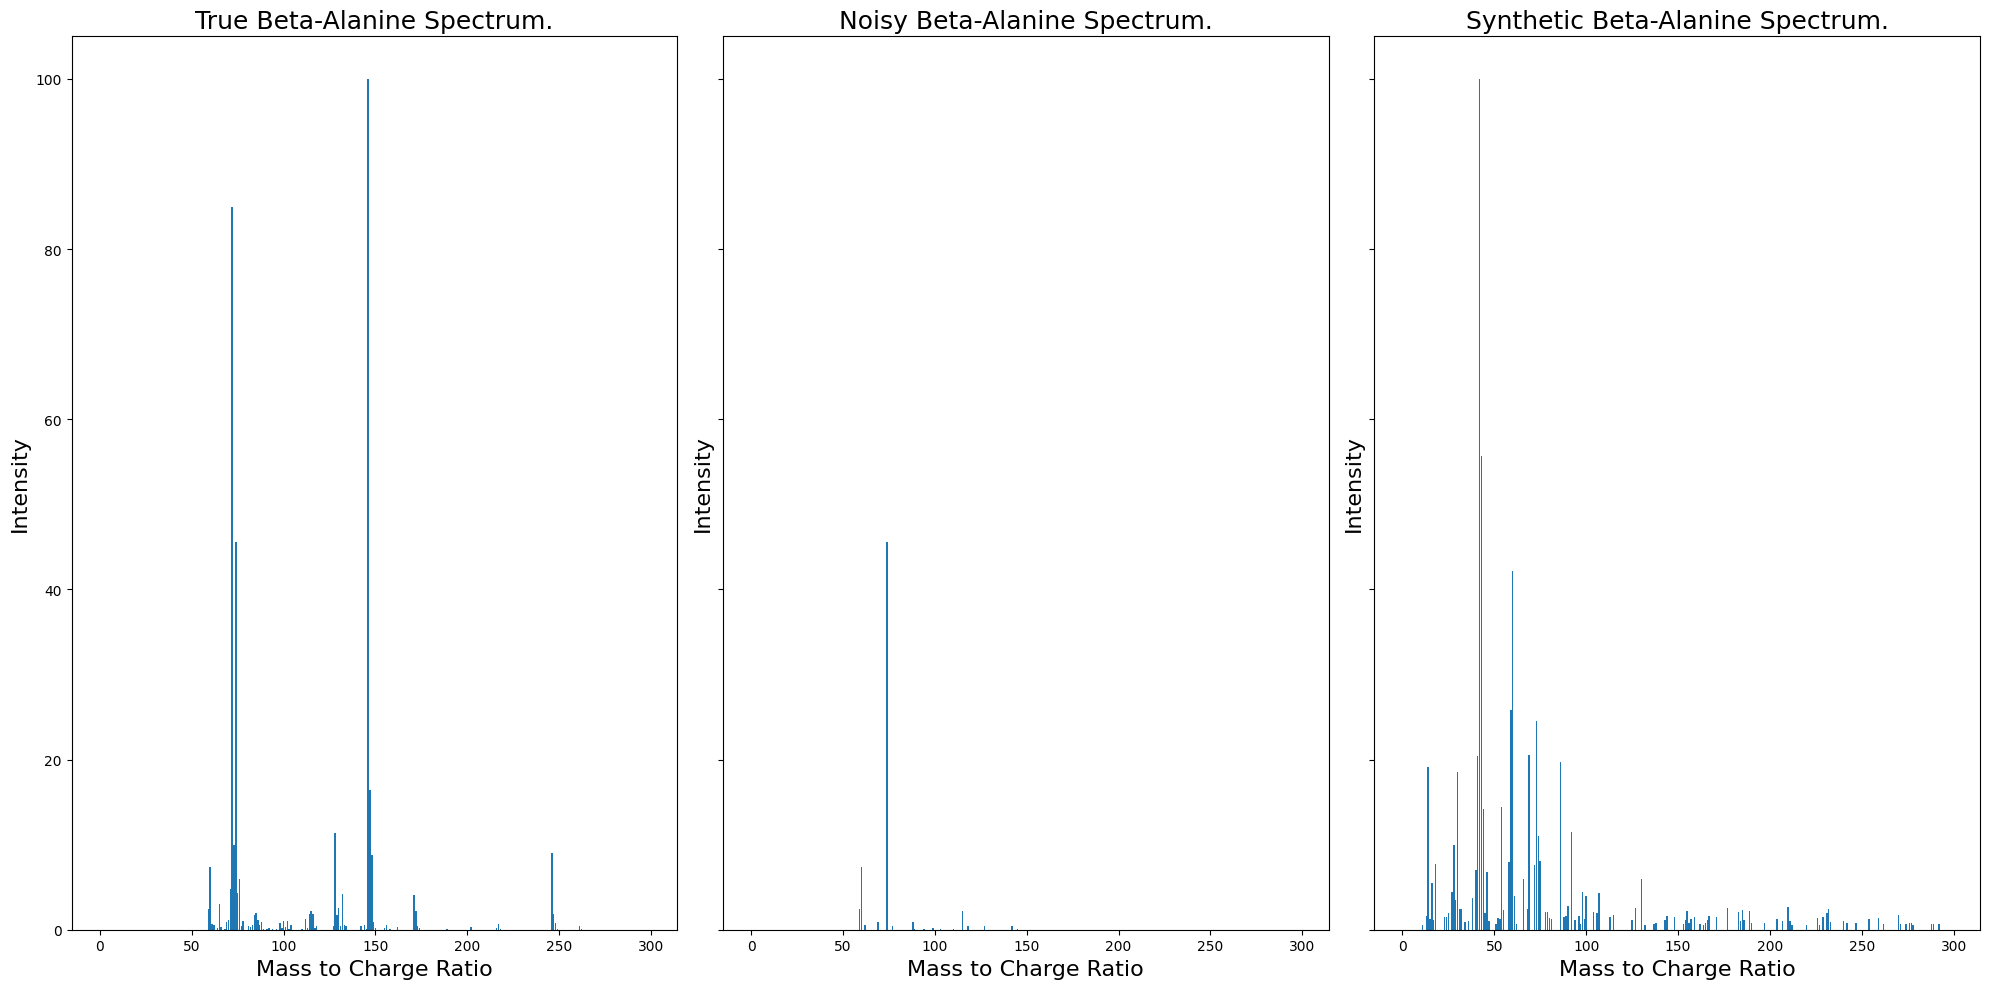

Weighted cosine similarity between true spectrum and noisy spectrum is:  0.8811
Weighted cosine similarity between true spectrum and output spectrum is:  0.8642


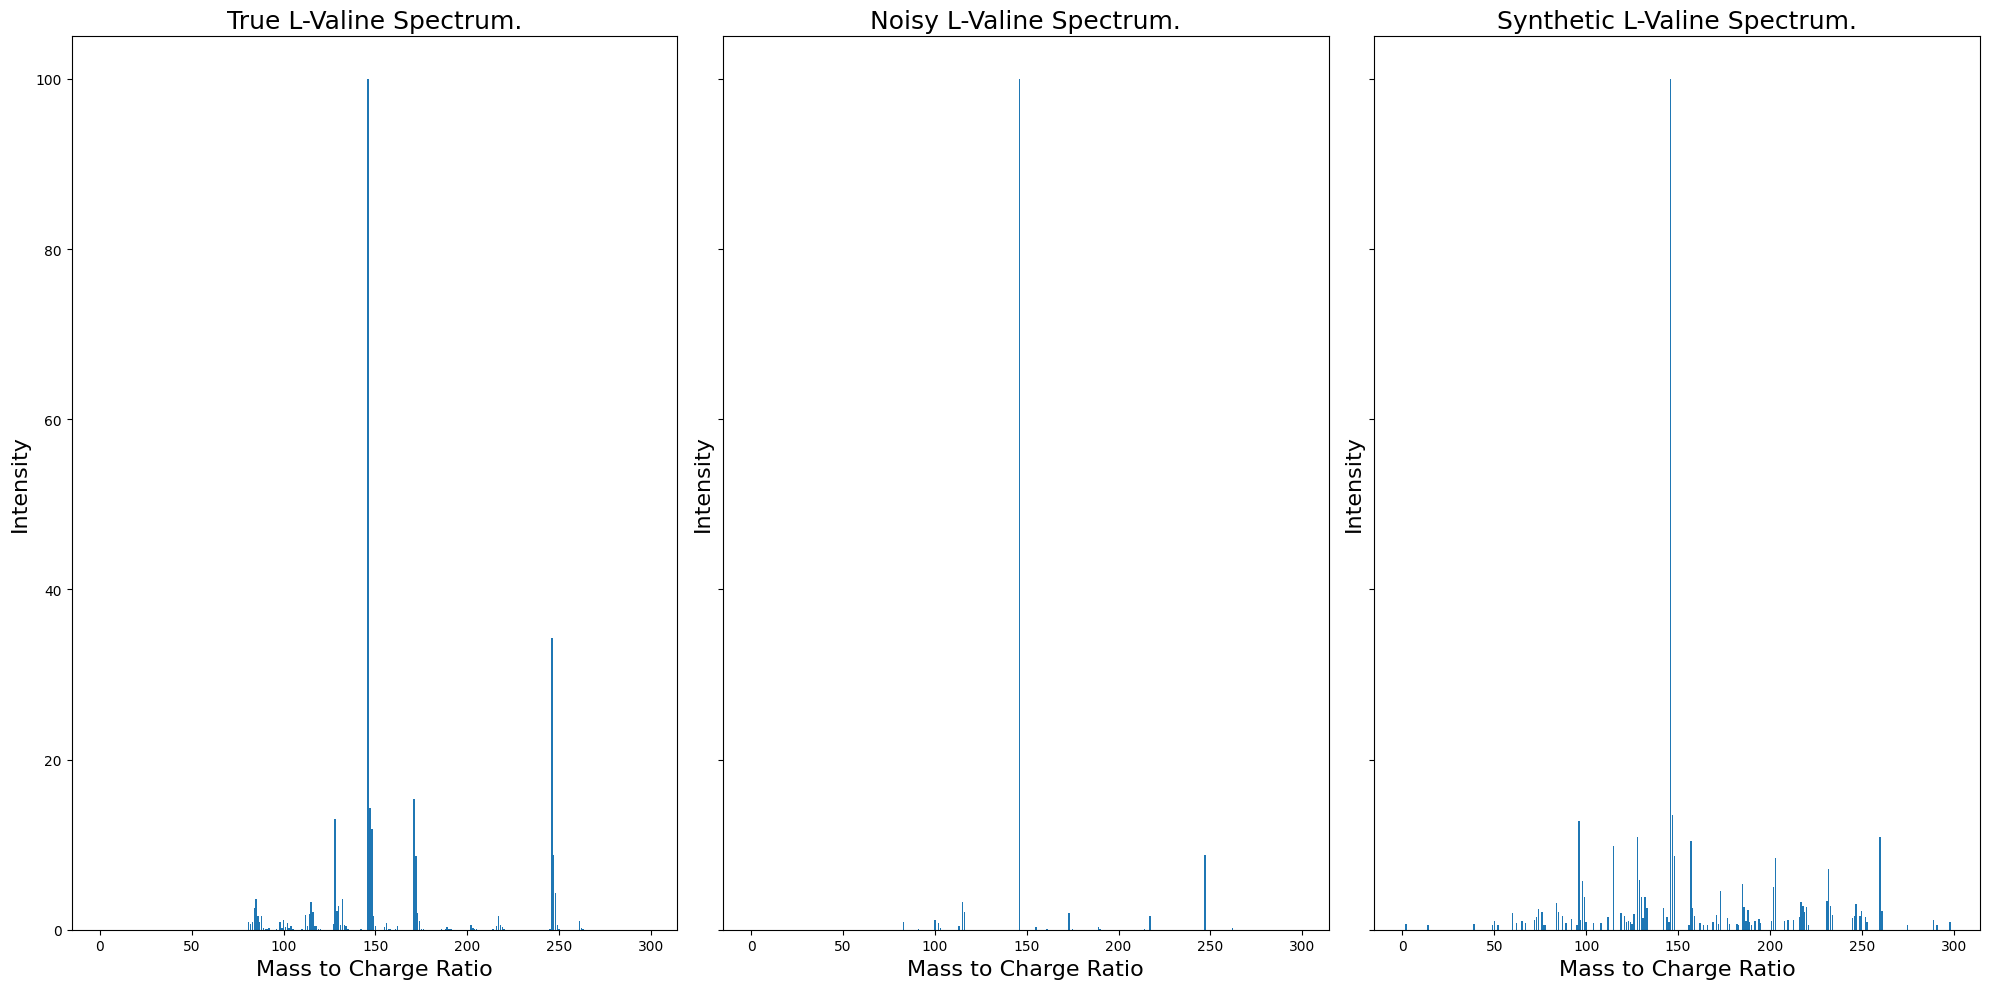

Weighted cosine similarity between true spectrum and noisy spectrum is:  0.1186
Weighted cosine similarity between true spectrum and output spectrum is:  0.4713


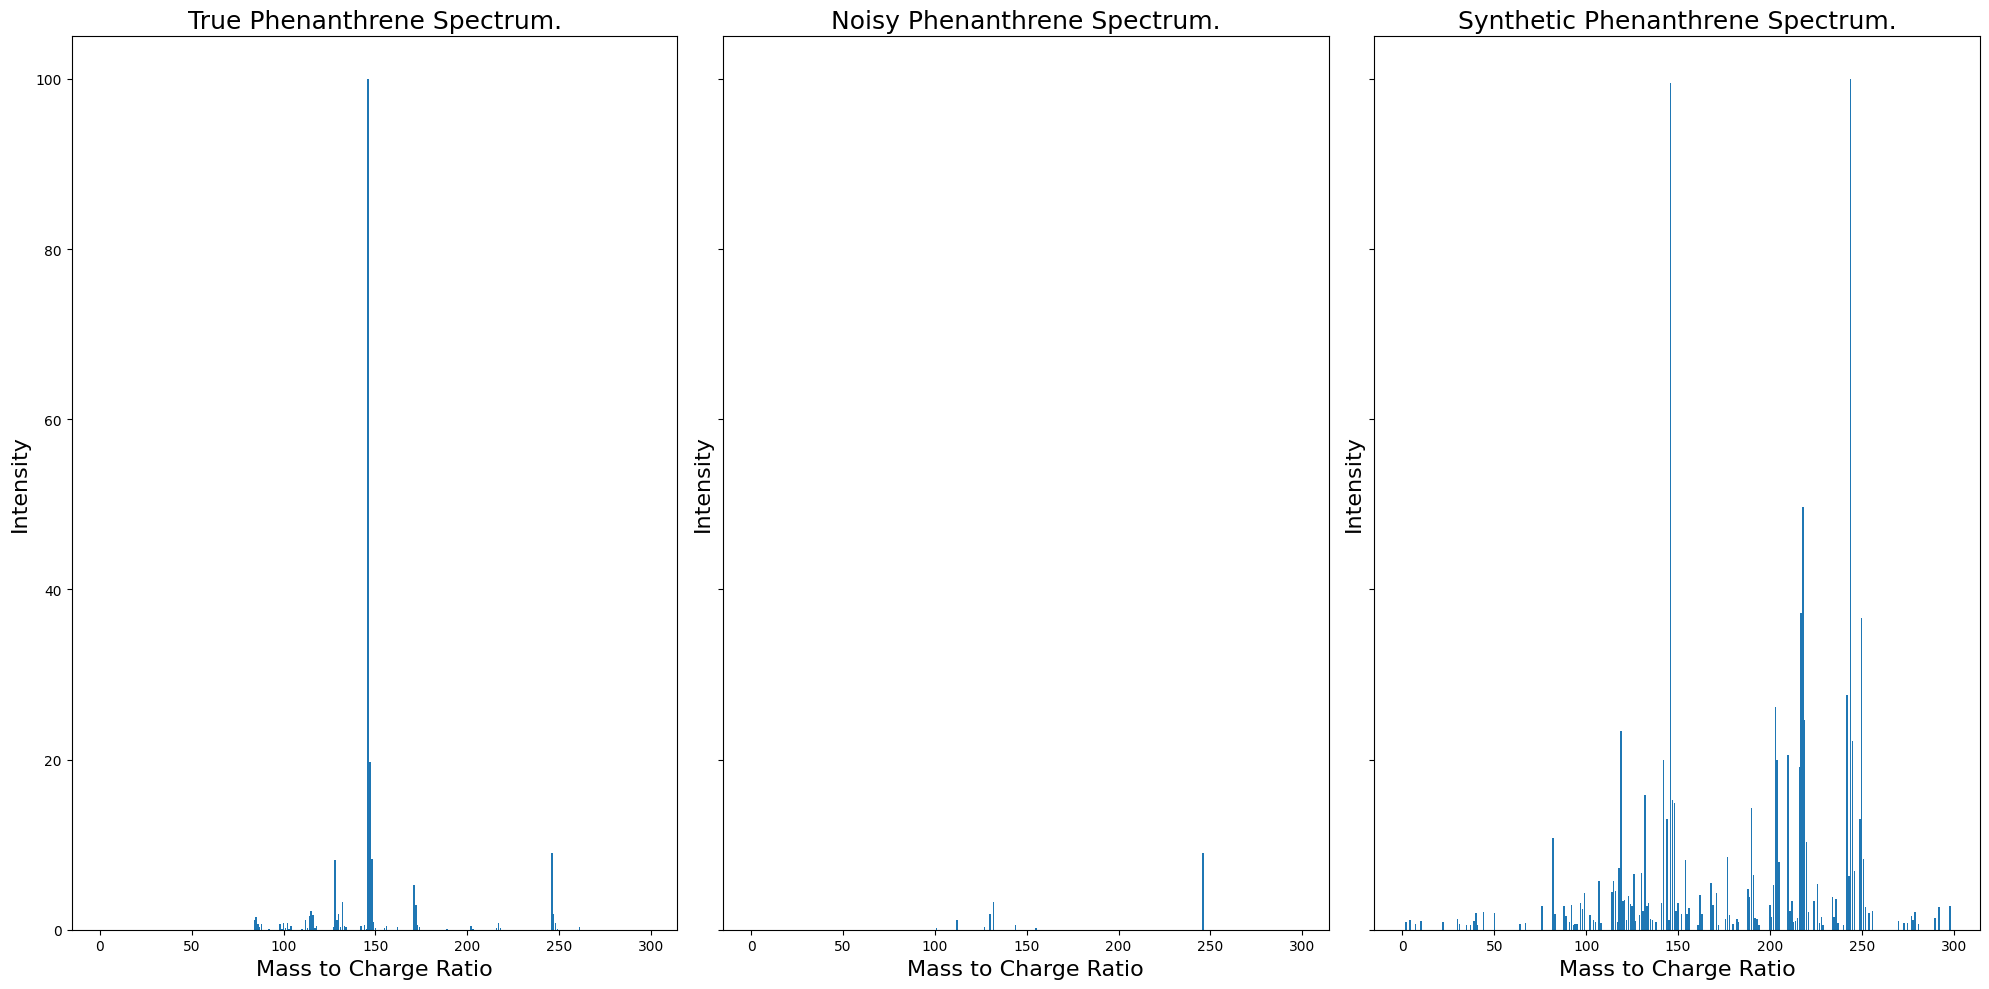

In [20]:
plotting_true_spectra = [vec.detach().numpy() for vec in test_true_spectra]
plotting_input_spectra = [vec.detach().numpy() for vec in test_input_spectra]
output_spectra = [vec.detach().numpy() for vec in test_output]

plot_results_with_input(plotting_true_spectra, plotting_input_spectra, output_spectra, output_labels, idx=[0,3])